This notebook shows the analysis of the 29 diamonds whos results are in the thesis.

In [2]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
#import qutip as qt
import os,sys,inspect
import sklearn as sk
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

The autoreload extension is already loaded. To reload it, use:


/Users/juan/anaconda/envs/python2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


  %reload_ext autoreload


In [3]:
diamonds = []
num_diamonds = 29
for diamond_num in range(num_diamonds):
    diamond = learning.load_obj("diamonds/diamond_" + str(diamond_num))
    diamonds.append(diamond)

In [4]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [14]:
diamonds[0].keys()

['A',
 'tau',
 'B',
 'successful_fits',
 'windows',
 'data',
 'N_data',
 'error_tol',
 'N',
 'N_vals',
 'num_subsets',
 'xs_list',
 'costheta',
 'scaled_errors',
 'phis_list',
 'r',
 'dip_inds',
 'sintheta',
 'good_fits']

In [37]:
for llave in diamonds[0].keys():
    print llave,":",
    try:
        print len(diamonds[0][llave])
    except:
        print "val:",diamonds[0][llave]

A : 467
tau : 5100
B : 467
successful_fits : 1114
windows : 1114
data : 5100
N_data : 128
error_tol : val: 0.0015625
N : val: 64
N_vals : 128
num_subsets : val: 4
xs_list : 1114
costheta : 467
scaled_errors : 1114
phis_list : 1114
r : 467
dip_inds : 1114
sintheta : 467
good_fits : 1114


In [61]:
diamonds[0]['windows']

array([[3795, 3810],
       [4840, 4855],
       [2107, 2121],
       ..., 
       [3888, 3890],
       [1753, 1755],
       [2361, 2363]])

In [63]:
range(10)[0:4]

[0, 1, 2, 3]

In [66]:
the_times = 10**6*diamonds[0]['tau']

/Users/juan/anaconda/envs/python2/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 5100 but corresponding boolean dimension is 1114


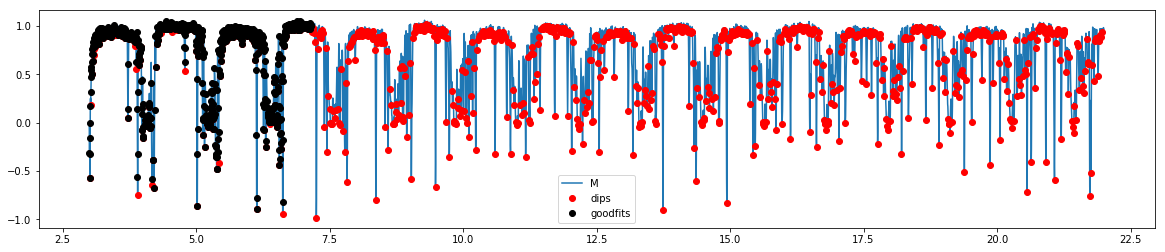

In [114]:
plt.figure(figsize=(20,4))
the_times = 10**6*diamonds[0]['tau']
the_data = diamonds[0]['data']
good_ones = np.array(diamonds[0]['good_fits'])
plt.plot(the_times,the_data,label='M')
plt.plot(the_times[diamonds[0]['dip_inds']],the_data[diamonds[0]['dip_inds']],'ro',label='dips')
plt.plot(the_times[good_ones],the_data[good_ones],'ko',label='goodfits')
plt.legend()
#for ventana in diamonds[0]['windows']:
#    plt.plot(the_times[ventana[0]:ventana[1]],(-0.1)+the_data[ventana[0]:ventana[1]],'r--')
#plt.xlim(15,17.5)
plt.show()

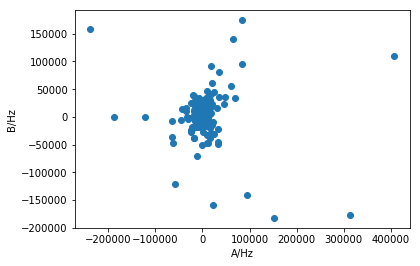

In [46]:
plt.figure()
plt.scatter(diamonds[1]['A'],diamonds[1]['B'])
plt.xlabel('A/Hz')
plt.ylabel('B/Hz')
plt.show()

In [76]:
the_times[3220]

14.998431064914689

In [120]:
%store spin_dict

Stored 'spin_dict' (dict)


In [121]:
# What is Michael doing here?
# First he imports two sklearn objects: a scaler and a classifier.
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
dips_measured = []
# He then iterates through all of the 29 diamonds.
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"] # This is an array with all the free evolution times.
    data = diamond["data"] # These are the corresping M(tau) values for N = 64
    N = diamond["N"]
    dip_inds = diamond["dip_inds"] # indices for the dips in data
    windows = diamond["windows"] # these indices determine the window around each dip
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds))) # only times after 15 micros are taken
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii: # this loop iterates over all dips
        if diamond["good_fits"][dii]: # If this happens to be a good fit then
            dip_ind = dip_inds[dii] 
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features): # this defines a pipeline with scaler and classifier.
        return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  0
dips measured:  374
num_removed:  4
correct:  19 incorrect:  6
diamond_ind:  1
dips measured:  429
num_removed:  0
correct:  21 incorrect:  4
diamond_ind:  2
dips measured:  431
num_removed:  0
correct:  16 incorrect:  9
diamond_ind:  3
dips measured:  357
num_removed:  1
correct:  14 incorrect:  2
diamond_ind:  4
dips measured:  426
num_removed:  1
correct:  11 incorrect:  2
diamond_ind:  5
dips measured:  406
num_removed:  1
correct:  22 incorrect:  3
diamond_ind:  6
dips measured:  406
num_removed:  0
correct:  14 incorrect:  2
diamond_ind:  7
dips measured:  375
num_removed:  0
correct:  14 incorrect:  1
diamond_ind:  8
dips measured:  390
num_removed:  0
correct:  16 incorrect:  1
diamond_ind:  9
dips measured:  445
num_removed:  0
correct:  18 incorrect:  7
diamond_ind:  10
dips measured:  388


analysis.py:61: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt((1 - mz ** 2)) * omega_tilde


num_removed:  0
correct:  10 incorrect:  0
diamond_ind:  11
dips measured:  385
num_removed:  0
correct:  10 incorrect:  3
diamond_ind:  12
dips measured:  375
num_removed:  0
correct:  9 incorrect:  1
diamond_ind:  13
dips measured:  402
num_removed:  0
correct:  12 incorrect:  1
diamond_ind:  14
dips measured:  397
num_removed:  0
correct:  18 incorrect:  0
diamond_ind:  15
dips measured:  379
num_removed:  1
correct:  13 incorrect:  2
diamond_ind:  16
dips measured:  372
num_removed:  0
correct:  15 incorrect:  3
diamond_ind:  17
dips measured:  387
num_removed:  0
correct:  14 incorrect:  4
diamond_ind:  18
dips measured:  407
num_removed:  3
correct:  22 incorrect:  2
diamond_ind:  19
dips measured:  401
num_removed:  1
correct:  12 incorrect:  4
diamond_ind:  20
dips measured:  375
num_removed:  1
correct:  13 incorrect:  3
diamond_ind:  21
dips measured:  381
num_removed:  1
correct:  23 incorrect:  1
diamond_ind:  22
dips measured:  433
num_removed:  5
correct:  13 incorrect:  

In [100]:
np.mean(num_correct_list), np.mean(num_incorrect_list)

(15.0, 2.7241379310344827)

In [2]:
#results_dict = {"As_list" : As_list, "Bs_list" : Bs_list,
#                "num_correct_list" : num_correct_list, "num_incorrect_list" : num_incorrect_list, "dips_measured" : dips_measured}
#learning.store_obj(results_dict, "results/results_di3220_29diamonds_cxABe_x1")
results_dict = learning.load_obj("results/results_di3220_29diamonds_cxABe_x1")
As_list = results_dict["As_list"]
Bs_list = results_dict["Bs_list"]
num_correct_list = results_dict["num_correct_list"]
num_incorrect_list = results_dict["num_incorrect_list"]
dips_measured = results_dict["dips_measured"]
#print np.mean(results_dict["num_correct_list"])#, num_correct_list
#print results_dict["num_incorrect_list"]#, num_incorrect_list
#As_list = results_dict["As_list"]
#Bs_list = results_dict["Bs_list"]

In [5]:
np.mean(np.array(dips_measured) * 128 + 5100)

55298.068965517239

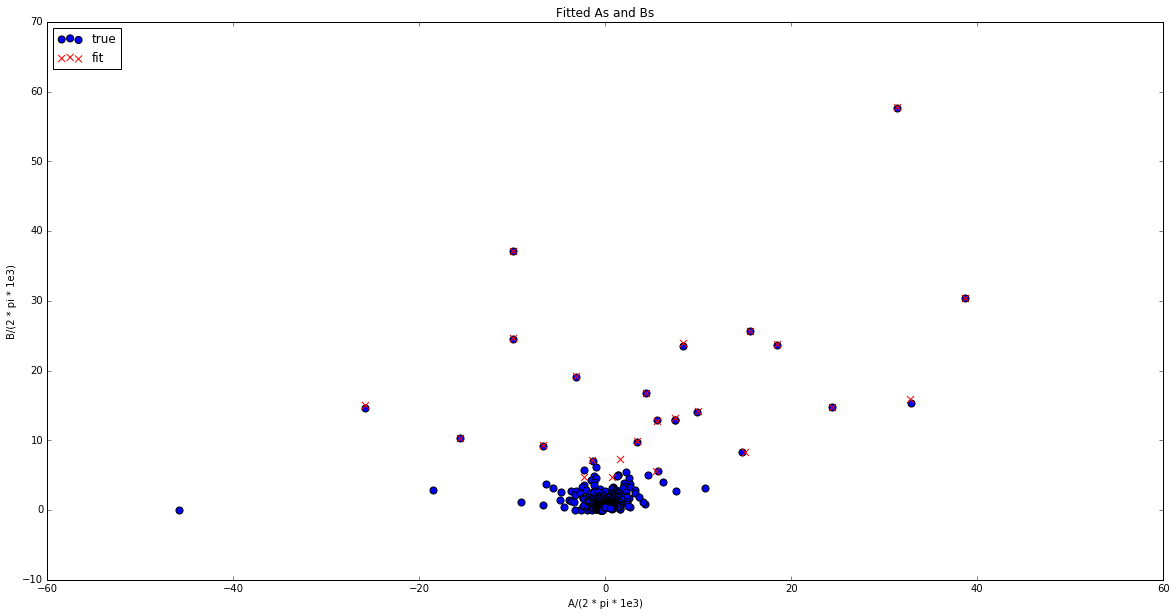

In [83]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(20,10))
plt.title("Fitted As and Bs")
plt.xlabel("A/(2 * pi * 1e3)")
plt.ylabel("B/(2 * pi * 1e3)")
plt.scatter(diamonds[diamond_ind]["A"]/analysis.mag, np.abs(diamonds[diamond_ind]["B"])/analysis.mag, c='b', marker = 'o', s = 50, label = 'true')
plt.scatter(As_list[diamond_ind]/analysis.mag, np.abs(Bs_list[diamond_ind])/analysis.mag, c='r', marker = 'x', s = 50, label = 'fit')
plt.legend(loc=2)
plt.show()